# Structural Break Detection Results

This notebook contains the comparative analysis of three structural break detectors:
- WBS2 SDLL
- Spike-and-Slab
- BiLSTM


## 1. Setup & Imports

This section loads all necessary libraries and modules for the benchmarking experiments.


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from typing import Dict, Optional
import torch
from collections import defaultdict
from matplotlib import cm


## 2. Synthetic Data Generation

Generate synthetic time series datasets with known structural breaks for testing detector performance.

**Datasets:**
- Dataset 1: 100 series, length 500, min break distance 50
- Dataset 2: 100 series, length 1000, min break distance 100

**Break types include:**
- Mean shifts
- Variance shifts
- Trend breaks
- Autocorrelation changes
- Combined breaks


In [2]:
from synthetic_data_generator import StructuralBreakGenerator

In [ ]:
from pelt_detector import run_pelt_benchmark

# You can tune penalties if needed; these are reasonable defaults
_ = run_pelt_benchmark(model='l2', min_size=10, penalty_500=8.0, penalty_1000=10.0)


In [3]:
# Create generator
generator = StructuralBreakGenerator(seed=42)

# Generate and save the first dataset
print("Generating first dataset (100 series, length 500, min_break_distance 50)...")
dataset_500 = generator.generate_dataset(n_series=100, series_length=500, max_breaks=3, min_break_distance=50)
dataset_500.to_pickle('synthetic_breaks_100_500_min50.pkl')
print("First dataset saved as 'synthetic_breaks_100_500_min50.pkl'")

# Generate and save the second dataset
print("\nGenerating second dataset (100 series, length 1000, min_break_distance 100)...")
dataset_1000 = generator.generate_dataset(n_series=100, series_length=1000, max_breaks=3, min_break_distance=100)
dataset_1000.to_pickle('synthetic_breaks_100_1000_min100.pkl')
print("Second dataset saved as 'synthetic_breaks_100_1000_min100.pkl'")

Generating first dataset (100 series, length 500, min_break_distance 50)...
Generating 100 synthetic time series...
Series Length: 500, Max Breaks: 3, Min Break Distance: 50

Dataset Summary:
Total series: 100
Break count distribution:
n_breaks
0    25
1    25
2    30
3    20
Name: count, dtype: int64

Break type distribution:
primary_break_type
none              25
combined_break    19
autocorr_shift    16
trend_break       14
variance_shift    14
mean_shift        12
Name: count, dtype: int64
First dataset saved as 'synthetic_breaks_100_500_min50.pkl'

Generating second dataset (100 series, length 1000, min_break_distance 100)...
Generating 100 synthetic time series...
Series Length: 1000, Max Breaks: 3, Min Break Distance: 100

Dataset Summary:
Total series: 100
Break count distribution:
n_breaks
0    24
1    25
2    29
3    22
Name: count, dtype: int64

Break type distribution:
primary_break_type
none              24
autocorr_shift    16
trend_break       16
mean_shift        15
co

## 3. WBS2 SDLL Detector Benchmark

**Wild Binary Segmentation 2 with Steepest Drop to Low Levels**

This detector uses:
- Random/systematic CUSUM sampling
- Universal threshold with λ = 0.9
- Median-of-repeats aggregation

**Evaluation metrics:**
- Precision, Recall, F1-Score
- Localization error (mean delay in samples)
- Performance by break count and break type
- Runtime analysis


In [4]:
from wbs2_detector import RWBS2Detector, run_r_wbs2_benchmark, evaluate_detection_performance

=== R WBS2 Performance Benchmark ===

Dataset (500 length) loaded:
- Total series: 100
- Break distribution: {0: 25, 1: 25, 2: 30, 3: 20}

Dataset (1000 length) loaded:
- Total series: 100
- Break distribution: {0: 24, 1: 25, 2: 29, 3: 22}

--- Running Benchmark on 500 Length Series (R Implementation) ---
Running R WBS2 detection on 500 length series...
Processed 20 series...
Processed 40 series...
Processed 60 series...
Processed 80 series...
Processed 100 series...
Detection completed for 500 series in 4.89 seconds
Average time per 500 series (processed): 48.94 ms

Evaluating performance for 500 series with 1% tolerance...
=== R WBS2 Performance Results (500 Series, 1% Tolerance) ===
Tolerance used: 5
Overall Precision: 0.033
Overall Recall: 0.683
Overall F1-Score: 0.063

Average Precision: 0.086
Average Recall: 0.696
Average F1-Score: 0.143

Average Localization Error: 2.5 time points

Confusion Matrix:
True Positives: 99
False Positives: 2905
False Negatives: 46

=== Performance by

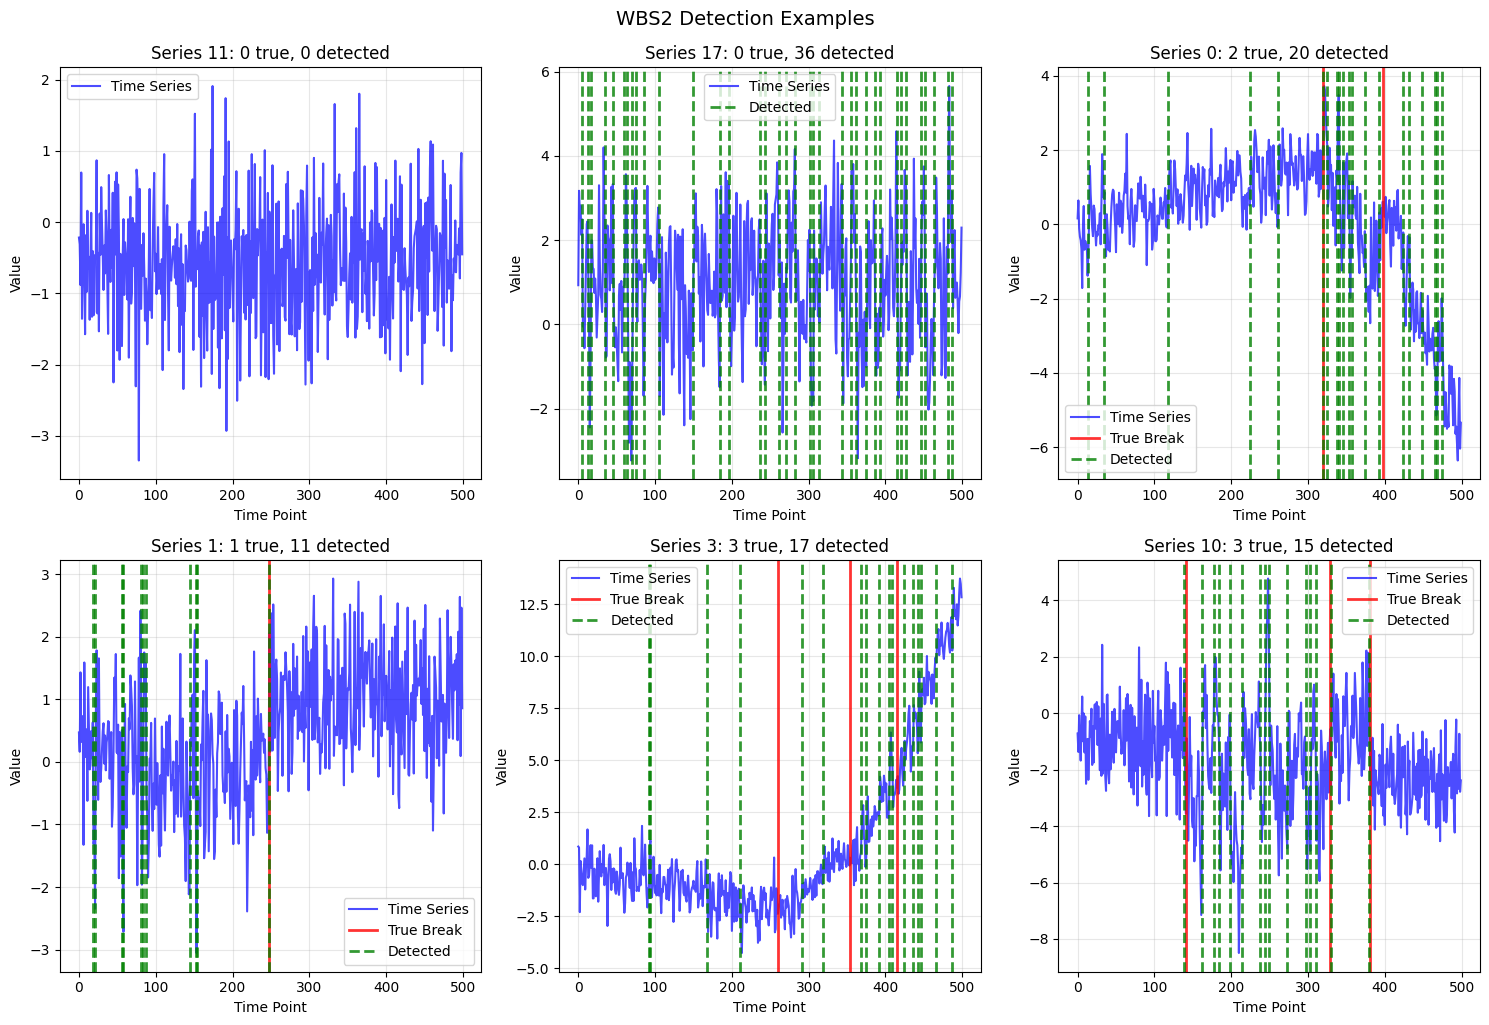



--- Running Benchmark on 1000 Length Series (R Implementation) ---
Running R WBS2 detection on 1000 length series...
Processed 20 series...
Processed 40 series...
Processed 60 series...
Processed 80 series...
Processed 100 series...
Detection completed for 1000 series in 9.82 seconds
Average time per 1000 series (processed): 98.23 ms

Evaluating performance for 1000 series with 1% tolerance...
=== R WBS2 Performance Results (1000 Series, 1% Tolerance) ===
Tolerance used: 10
Overall Precision: 0.015
Overall Recall: 0.738
Overall F1-Score: 0.030

Average Precision: 0.035
Average Recall: 0.717
Average F1-Score: 0.075

Average Localization Error: 4.3 time points

Confusion Matrix:
True Positives: 110
False Positives: 7065
False Negatives: 39

=== Performance by Break Count (1000 Series, 1% Tolerance) ===
0 breaks (24 series): P=0.000, R=0.000, F1=0.000, LocErr=0.0
1 breaks (25 series): P=0.011, R=0.680, F1=0.021, LocErr=3.4
2 breaks (29 series): P=0.016, R=0.672, F1=0.032, LocErr=4.1
3 b

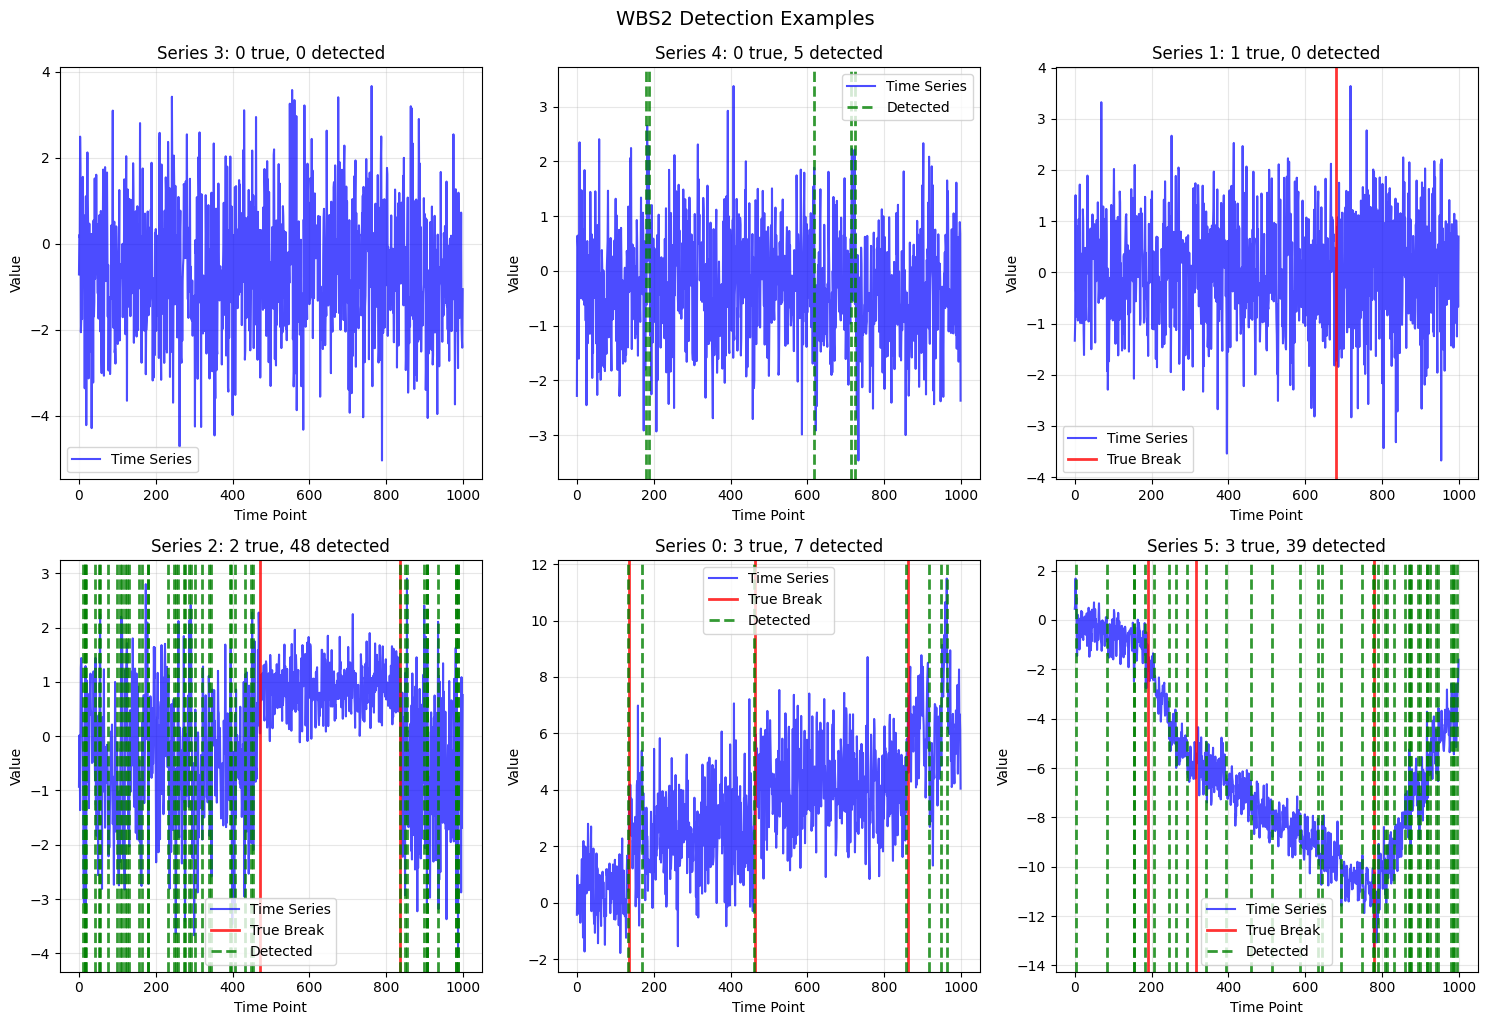

In [5]:
results = run_r_wbs2_benchmark()

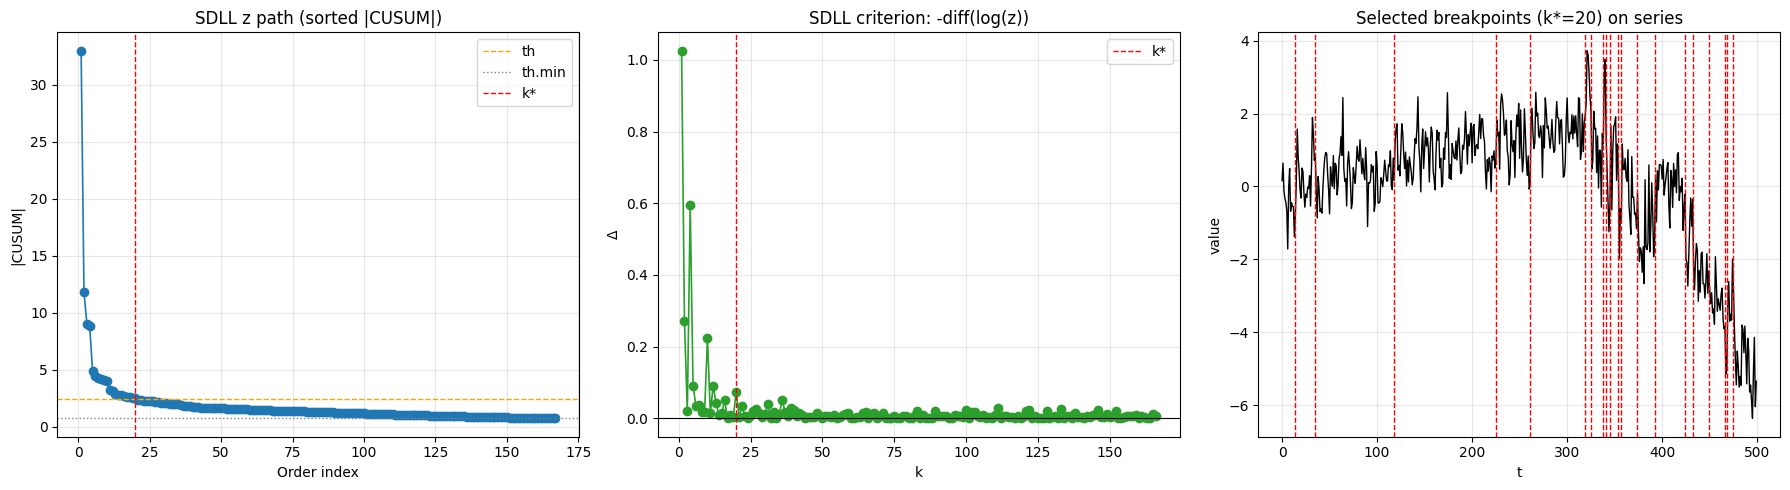

In [13]:
from wbs2_detector import plot_sdll_path

df = pd.read_pickle('synthetic_breaks_100_500_min50.pkl')
series = df.loc[0, [c for c in df.columns if c.startswith('t_')]].to_numpy(dtype=float)

plot_sdll_path(series, universal=True, lambda_param=0.9, cusums="systematic")

Detected breaks: [14, 35, 118, 225, 261, 319, 325, 338, 341, 345, 353, 357, 374, 392, 424, 432, 449, 466, 468, 475]


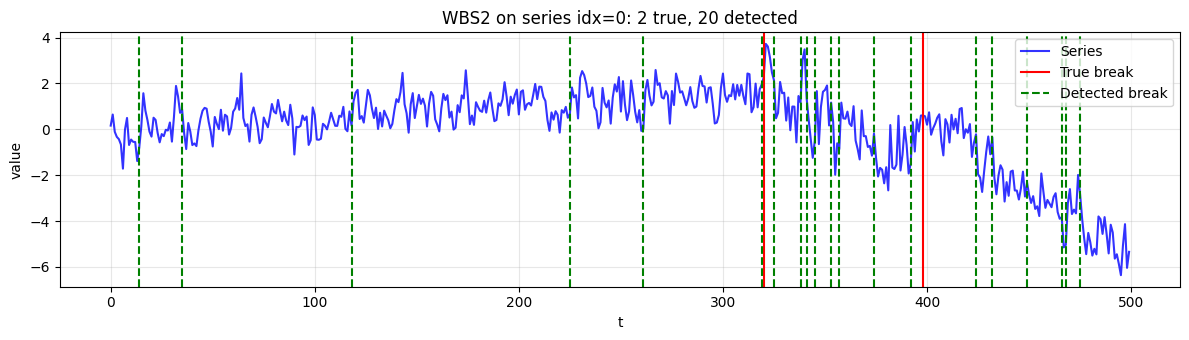

In [4]:
import matplotlib.pyplot as plt

# Run the same detector on the same 'series' used for the SDLL path
# Assumes variables 'df' and 'series' are already defined as in the previous cell

# If you want a different row, set idx accordingly
idx = 0
true_bp = df.loc[idx, 'break_points'] if 'break_points' in df.columns else []

# Initialize and run detector
wbs2 = RWBS2Detector(universal=True, lambda_param=0.9, cusums="systematic")
detected_bp = wbs2.detect_breaks_fast(series)
print("Detected breaks:", detected_bp)

# Overlay plot: time series with true (red) and detected (green dashed)
plt.figure(figsize=(12, 3.5))
plt.plot(series, 'b-', alpha=0.8, label='Series')

first = True
for bp in (true_bp or []):
    plt.axvline(bp, color='red', linestyle='-', linewidth=1.5,
                label='True break' if first else '')
    first = False

first = True
for bp in (detected_bp or []):
    plt.axvline(bp, color='green', linestyle='--', linewidth=1.5,
                label='Detected break' if first else '')
    first = False

plt.legend(loc='upper right')
plt.title(f"WBS2 on series idx={idx}: {len(true_bp or [])} true, {len(detected_bp or [])} detected")
plt.xlabel('t')
plt.ylabel('value')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Spike-and-Slab Detector Benchmark

**Bayesian Changepoint Detection with Spike-and-Slab Priors**

This detector uses:
- Spike prior: τ²_spike = 1/n (small jumps)
- Slab prior: τ²_slab = n (large jumps)
- Posterior inclusion probability ratio ≥ 0.5
- Single-series Bayesian inference

**Evaluation metrics:**
- Precision, Recall, F1-Score
- Localization error
- Performance by break count and break type
- Runtime comparison


In [14]:
from spike_slab_detector import SpikeAndSlabDetector, run_spike_slab_benchmark

=== Spike-and-Slab Performance Benchmark ===

Dataset (500 length) loaded:
- Total series: 100
- Break distribution: {0: 25, 1: 25, 2: 30, 3: 20}

Dataset (1000 length) loaded:
- Total series: 100
- Break distribution: {0: 24, 1: 25, 2: 29, 3: 22}

--- Running Benchmark on 500 Length Series (Spike-and-Slab) ---
Running Spike-and-Slab detection on 500 length series...
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
Processed 20 series...
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
Processed 40 series...
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
Processed 60 series...
[1] "No change po

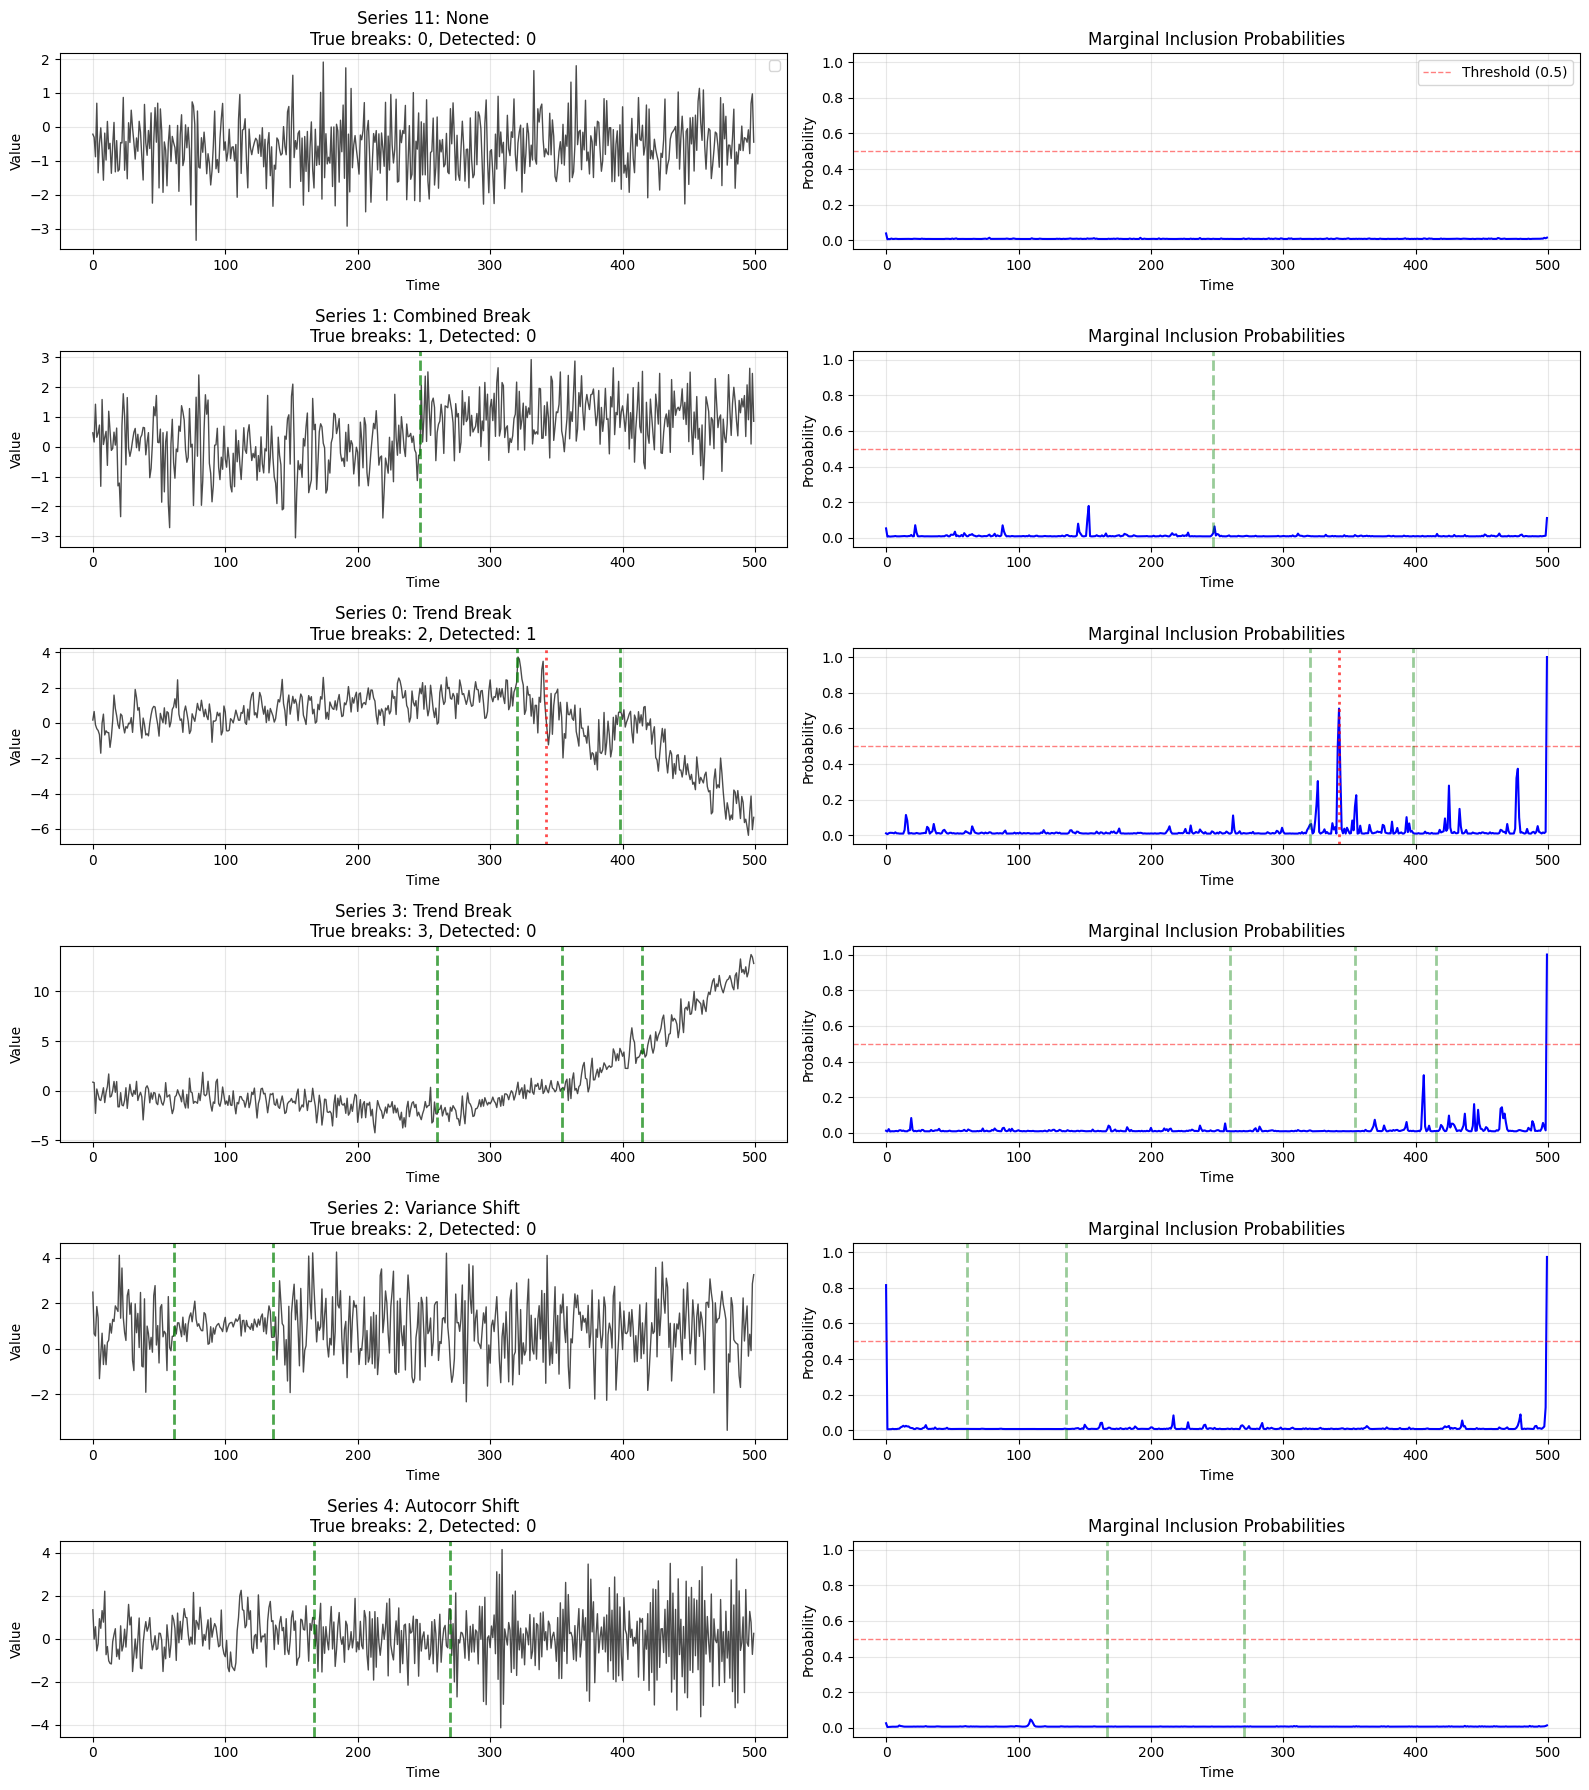



--- Running Benchmark on 1000 Length Series (Spike-and-Slab) ---
Running Spike-and-Slab detection on 1000 length series...
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
Processed 20 series...
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
Processed 40 series...
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
[1] "No change points detected"
Processed 60 series...
[1] "No change points detected"
[1] "No change points detected"
[1] "N

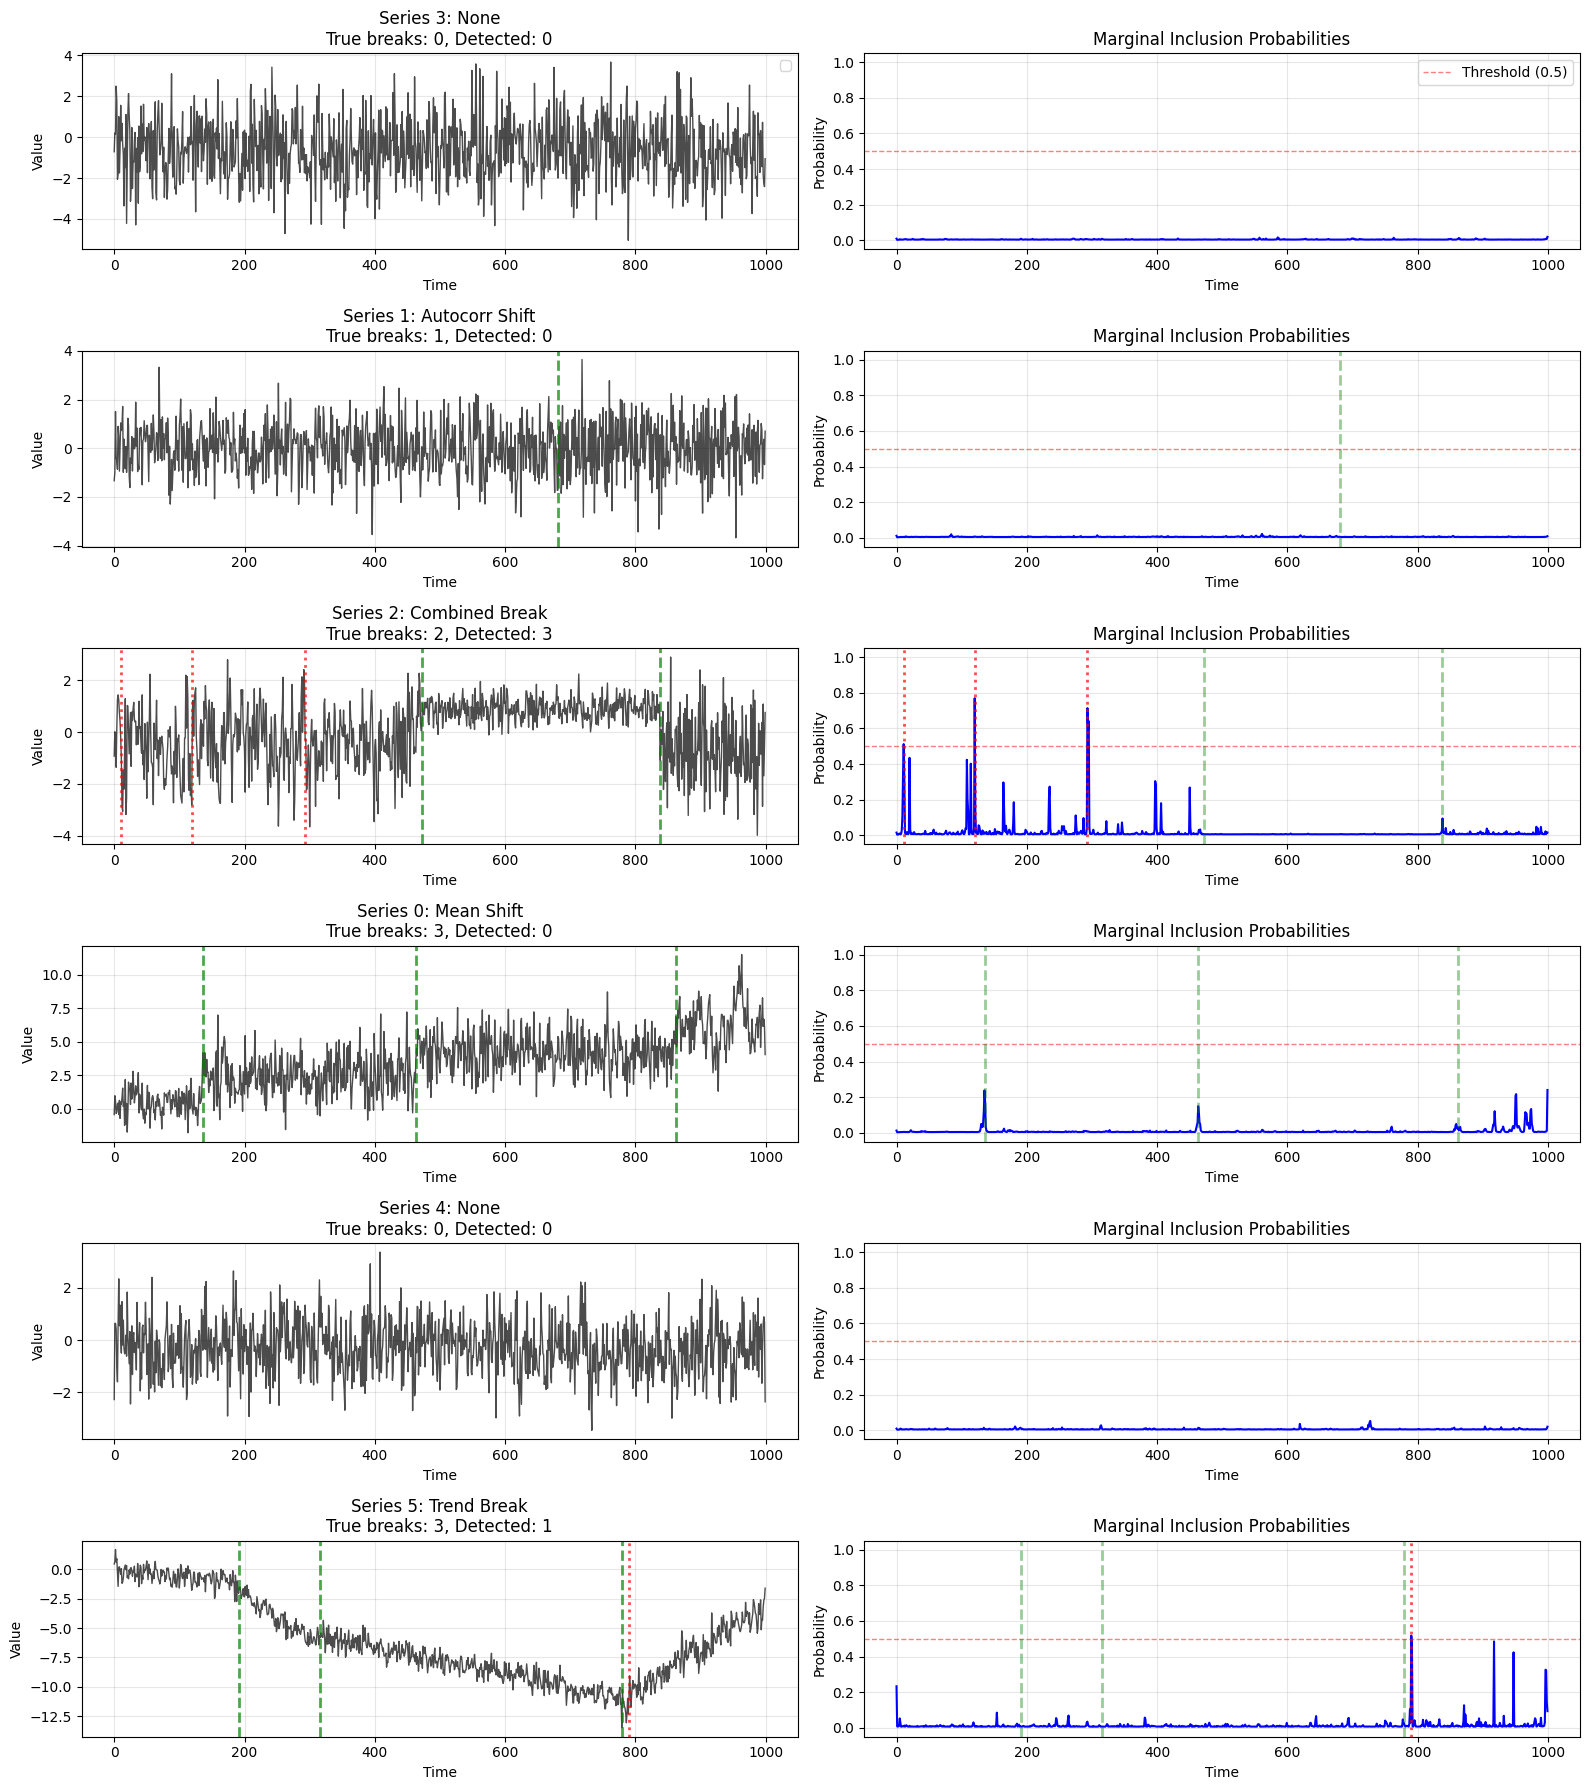

(    series_id  n_breaks     break_points primary_break_type  \
 0           0         2       [320, 398]        trend_break   
 1           1         1            [247]     combined_break   
 2           2         2        [61, 136]     variance_shift   
 3           3         3  [260, 354, 415]        trend_break   
 4           4         2       [167, 270]     autocorr_shift   
 ..        ...       ...              ...                ...   
 95         95         1            [373]     autocorr_shift   
 96         96         0               []               none   
 97         97         2       [339, 427]     variance_shift   
 98         98         2        [96, 432]     autocorr_shift   
 99         99         0               []               none   
 
                    model_type       t_0       t_1       t_2       t_3  \
 0      AR(1)_with_trend_break  0.161288  0.643479 -0.109611 -0.329992   
 1   AR(1)_with_combined_break  0.468780  0.160627  1.429130  0.318293   
 2   AR(

In [15]:
run_spike_slab_benchmark()

## 5. BiLSTM Detector Benchmark

**Bidirectional LSTM Neural Network for Structural Break Detection**

This detector uses:
- 2-layer BiLSTM with 64 hidden units
- Conv1D layers for sequence-to-sequence mapping
- Adaptive focal loss (pos_weight=8.0, gamma=2.0)
- 120-sample sliding window with stride=15
- Detection threshold=0.6 (optimized on validation)

**Evaluation metrics:**
- Precision, Recall, F1-Score
- Localization error
- Performance by break count and break type
- Runtime analysis (includes neural network inference)


In [16]:
from bilstm_detector import CleanBiLSTMDetector, evaluate_bilstm_by_break_type, evaluate_bilstm_by_break_count

In [17]:
# Instantiate the BiLSTM detector
# Check if CUDA is available and set device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
bilstm_detector = CleanBiLSTMDetector(device=device)
bilstm_benchmark_results = {}

# Load the pre-trained model
try:
    bilstm_detector.load_model('clean_bilstm_model.pth')
except FileNotFoundError:
    print("Error: clean_bilstm_model.pth not found. Please ensure the model is trained and saved.")
    # Exit the subtask gracefully if the model file is missing
    bilstm_benchmark_results = None # Indicate failure
except Exception as e:
    print(f"Error loading model: {e}")
    bilstm_benchmark_results = None # Indicate failure


if bilstm_benchmark_results is not None: # Only proceed if model loaded successfully
    # Dictionary to store results for each dataset
    bilstm_benchmark_results = {}
    datasets_to_benchmark = {
        '500_length': dataset_500,
        '1000_length': dataset_1000
    }

    # Threshold and stride for detection
    detection_threshold = 0.6 # Based on previous experimentation
    detection_stride = 15

    for dataset_name, dataset in datasets_to_benchmark.items():
        print(f"\n--- Running BiLSTM Detection on {dataset_name} Series ---")

        detected_breaks_list = []
        detection_times_ms = []

        # Dynamically determine series columns based on dataset columns
        series_columns = [col for col in dataset.columns if col.startswith('t_')]
        series_length = len(series_columns)

        if series_length == 0:
            print(f"Warning: No time series columns found in {dataset_name}. Skipping.")
            bilstm_benchmark_results[dataset_name] = {
                'detected_breaks': [],
                'runtimes_ms': []
            }
            continue


        try:
            for i in range(len(dataset)):
                if (i + 1) % 20 == 0: # Print progress every 20 series
                    print(f"Processed {i + 1:,}/{len(dataset):,} series in {dataset_name}...")

                # Extract time series data
                time_series = dataset.iloc[i][series_columns].values.astype(float)

                # Perform break detection and measure time
                start_time = time.time()
                detected_breaks = bilstm_detector.detect_breaks(
                    time_series,
                    threshold=detection_threshold,
                    stride=detection_stride
                )
                end_time = time.time()
                runtime_ms = (end_time - start_time) * 1000.0

                detected_breaks_list.append(detected_breaks)
                detection_times_ms.append(runtime_ms)

        except KeyboardInterrupt:
            print(f"\nBenchmark on {dataset_name} interrupted by user.")
            pass # Allow graceful exit on interruption

        # Store results for the current dataset
        bilstm_benchmark_results[dataset_name] = {
            'detected_breaks': detected_breaks_list,
            'runtimes_ms': detection_times_ms
        }

        # Print summary for the current dataset
        total_time = sum(detection_times_ms) / 1000.0 # Convert total time back to seconds
        print(f"Detection completed for {len(dataset)} series in {dataset_name} in {total_time:.2f} seconds")
        if detection_times_ms:
             print(f"Average time per series: {np.mean(detection_times_ms):.2f} ms")
        print()

    # The bilstm_benchmark_results dictionary now contains detected breaks and runtimes
    # for both datasets. This fulfills the requirements of the subtask.


Using device: cpu
✅ Loaded model from clean_bilstm_model.pth

--- Running BiLSTM Detection on 500_length Series ---
Processed 20/100 series in 500_length...
Processed 40/100 series in 500_length...
Processed 60/100 series in 500_length...
Processed 80/100 series in 500_length...
Processed 100/100 series in 500_length...
Detection completed for 100 series in 500_length in 17.98 seconds
Average time per series: 179.84 ms


--- Running BiLSTM Detection on 1000_length Series ---
Processed 20/100 series in 1000_length...
Processed 40/100 series in 1000_length...
Processed 60/100 series in 1000_length...
Processed 80/100 series in 1000_length...
Processed 100/100 series in 1000_length...
Detection completed for 100 series in 1000_length in 39.54 seconds
Average time per series: 395.36 ms



In [18]:
# Check if benchmark results are available
if 'bilstm_benchmark_results' not in locals() or bilstm_benchmark_results is None:
    print("BiLSTM benchmark results not found. Please run the detection step first.")
else:
    print("=== Evaluating BiLSTM Performance ===")

    bilstm_evaluated_results = {}

    for dataset_name, results in bilstm_benchmark_results.items():
        print(f"\n--- Evaluating Performance for {dataset_name} ---")

        dataset = None
        if dataset_name == '500_length':
            dataset = dataset_500
        elif dataset_name == '1000_length':
            dataset = dataset_1000
        else:
            print(f"Warning: Dataset '{dataset_name}' not recognized. Skipping evaluation for this dataset.")
            continue

        detected_breaks = results['detected_breaks']

        # Calculate overall metrics (need to adapt the overall evaluation logic for BiLSTM output)
        # We can calculate overall TP, FP, FN and then derive metrics
        total_tp, total_fp, total_fn = 0, 0, 0
        all_localization_errors = []

        # Dynamically determine series length for tolerance calculation
        series_cols = [col for col in dataset.columns if col.startswith('t_')]
        series_length = len(series_cols)
        evaluation_tolerance = max(1, int(series_length * (1.0 / 100.0)))
        print(f"Using tolerance of {evaluation_tolerance} for evaluation on {dataset_name} ({1.0}% of length {series_length})")


        for i in range(len(dataset)):
            true_breaks = dataset.iloc[i]['break_points']
            detected_bp = detected_breaks[i]

            # Calculate TP, FP, FN, and localization errors for the current series
            tp = 0
            matched_true_indices = set()
            matched_detected_indices = set()
            current_localization_errors = []

            for j, det_bp_val in enumerate(detected_bp): # Iterate through detected break points
                for k, true_bp_val in enumerate(true_breaks): # Iterate through true break points
                    if abs(det_bp_val - true_bp_val) <= evaluation_tolerance: # Compare detected to true with tolerance
                        if k not in matched_true_indices: # Ensure each true break is matched only once
                            matched_true_indices.add(k)
                            matched_detected_indices.add(j)
                            tp += 1
                            current_localization_errors.append(abs(det_bp_val - true_bp_val))
                            break # Move to the next detected break (found a match for this one)

            fp = len(detected_bp) - tp
            fn = len(true_breaks) - len(matched_true_indices)

            total_tp += tp
            total_fp += fp
            total_fn += fn
            all_localization_errors.extend(current_localization_errors)

        # Calculate overall metrics
        overall_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
        overall_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
        overall_f1 = 2 * overall_precision * overall_recall / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0.0
        overall_avg_localization_error = float(np.mean(all_localization_errors)) if all_localization_errors else 0.0


        print(f"\n=== Overall Performance Results for {dataset_name} ===")
        print(f"Overall Precision: {overall_precision:.3f}")
        print(f"Overall Recall: {overall_recall:.3f}")
        print(f"Overall F1-Score: {overall_f1:.3f}")
        print(f"Overall Avg Localization Error: {overall_avg_localization_error:.1f} time points")
        print(f"\nConfusion Matrix (Total for {dataset_name}):")
        print(f"True Positives: {total_tp}")
        print(f"False Positives: {total_fp}")
        print(f"False Negatives: {total_fn}")

        # Evaluate by break type
        try:
            # Pass the calculated tolerance to the evaluation functions
            results_by_type = evaluate_bilstm_by_break_type(dataset, detected_breaks)
            print(f"\n=== Performance by Break Type for {dataset_name} ===")
            for break_type, stats in results_by_type.items():
                 print(f"{break_type.replace('_',' ').title()} ({stats['n_series']} series):  "
                       f"P={stats['precision']:.3f}  R={stats['recall']:.3f}  F1={stats['f1_score']:.3f}  "
                       f"LocErr={stats['avg_localization_error']:.1f}")
        except NameError:
             print("Error: evaluate_bilstm_by_break_type function not found. Please ensure the cell defining it is run.")
             results_by_type = {}
        except Exception as e:
             print(f"Error during type evaluation for {dataset_name}: {e}")
             results_by_type = {}


        # Evaluate by break count
        try:
            # Pass the calculated tolerance to the evaluation functions
            results_by_count = evaluate_bilstm_by_break_count(dataset, detected_breaks)
            print(f"\n=== Performance by Break Count for {dataset_name} ===")
            for k in sorted(results_by_count.keys()):
                s = results_by_count[k]
                print(f"{k} breaks ({s['count']} series):  "
                      f"P={s['precision']:.3f}  R={s['recall']:.3f}  F1={s['f1_score']:.3f}  LocErr={s.get('avg_localization_error', 0.0):.1f}")
        except NameError:
            print("Error: evaluate_bilstm_by_break_count function not found. Please ensure the cell defining it is run.")
            results_by_count = {}
        except Exception as e:
             print(f"Error during count evaluation for {dataset_name}: {e}")
             results_by_count = {}


        # Store evaluated results for the current dataset
        bilstm_evaluated_results[dataset_name] = {
            'overall_precision': overall_precision,
            'overall_recall': overall_recall,
            'overall_f1': overall_f1,
            'overall_avg_loc_err': overall_avg_localization_error,
            'results_by_type': results_by_type,
            'results_by_count': results_by_count,
            'mean_runtime_ms': np.mean(results['runtimes_ms']) if results['runtimes_ms'] else 0.0,
            'median_runtime_ms': np.median(results['runtimes_ms']) if results['runtimes_ms'] else 0.0,
            'total_time_s': sum(results['runtimes_ms']) / 1000.0 if results['runtimes_ms'] else 0.0,
            'n_series': len(dataset),
            'series_length': series_length,
            'detection_threshold': detection_threshold,
            'detection_stride': detection_stride,
            'tolerance': evaluation_tolerance
        }

=== Evaluating BiLSTM Performance ===

--- Evaluating Performance for 500_length ---
Using tolerance of 5 for evaluation on 500_length (1.0% of length 500)

=== Overall Performance Results for 500_length ===
Overall Precision: 0.232
Overall Recall: 0.441
Overall F1-Score: 0.304
Overall Avg Localization Error: 2.1 time points

Confusion Matrix (Total for 500_length):
True Positives: 64
False Positives: 212
False Negatives: 81
Using tolerance of 5 for evaluation by break type (1.0% of length 500)

=== Performance by Break Type for 500_length ===
Autocorr Shift (16 series):  P=0.064  R=0.100  F1=0.078  LocErr=2.0
Combined Break (19 series):  P=0.386  R=0.710  F1=0.500  LocErr=1.7
Mean Shift (12 series):  P=0.425  R=0.708  F1=0.531  LocErr=2.4
None (25 series):  P=0.000  R=0.000  F1=0.000  LocErr=0.0
Trend Break (14 series):  P=0.063  R=0.138  F1=0.087  LocErr=0.2
Variance Shift (14 series):  P=0.514  R=0.581  F1=0.545  LocErr=2.6
Using tolerance of 5 for evaluation by break count (1.0% of

---

## 6. Real-World Data Analysis

Now we test all three detectors on real stock market data where ground truth is validated.

**Dataset:**
- 100 equity time series (daily returns, 2000-2017)
- Series length: ~1000 points



In [8]:
real_stock_dataset = pd.read_pickle('validated_stock_breaks.pkl')

print("Shape of real_stock_dataset:", real_stock_dataset.shape)
display(real_stock_dataset.head())

Shape of real_stock_dataset: (100, 1006)


,series_id,n_breaks,break_points,primary_break_type,stock_symbols,data_source,t_0,t_1,t_2,t_3,...,t_990,t_991,t_992,t_993,t_994,t_995,t_996,t_997,t_998,t_999
0,0,1,[292],cross_sector_random,"[UNH, C]",real_stock_returns_validated,0.003077,0.002162,-0.002372,-0.002028,...,0.013860,-0.008218,0.008218,0.007597,-0.015253,-0.009984,0.010181,0.013231,-0.000926,-0.004271
1,1,0,[],no_break,[BA],real_stock_returns_validated,-0.000571,0.006836,-0.015447,0.014026,...,0.020416,0.005065,-0.008320,-0.007671,-0.004940,-0.008705,0.011589,-0.013256,-0.003656,-0.006193
2,2,1,[699],volatility_shift,"[AMZN, CVX]",real_stock_returns_validated,-0.009069,-0.011985,0.087543,0.068430,...,0.002680,-0.003267,-0.002941,0.003864,0.008930,0.000581,-0.017084,-0.017897,0.001204,0.003515
3,3,0,[],no_break,[PG],real_stock_returns_validated,-0.000972,0.008075,-0.006239,-0.005194,...,0.004623,0.013591,-0.010673,-0.008158,0.006470,-0.001690,0.004604,0.002141,0.000153,0.009881
4,4,1,[673],sector_rotation,"[MSFT, WFC]",real_stock_returns_validated,-0.023133,0.026200,0.001700,0.007445,...,-0.008758,-0.010612,0.019021,-0.012640,-0.025408,-0.007276,0.005098,-0.009123,-0.003673,-0.011099


/var/folders/wy/n672xszx4h7d_0lnvp72zfbr0000gn/T/ipykernel_74609/2930291350.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  _palette = [cm.get_cmap('tab20')(i % 20) for i in range(max(1, len(_unique_symbols)))]


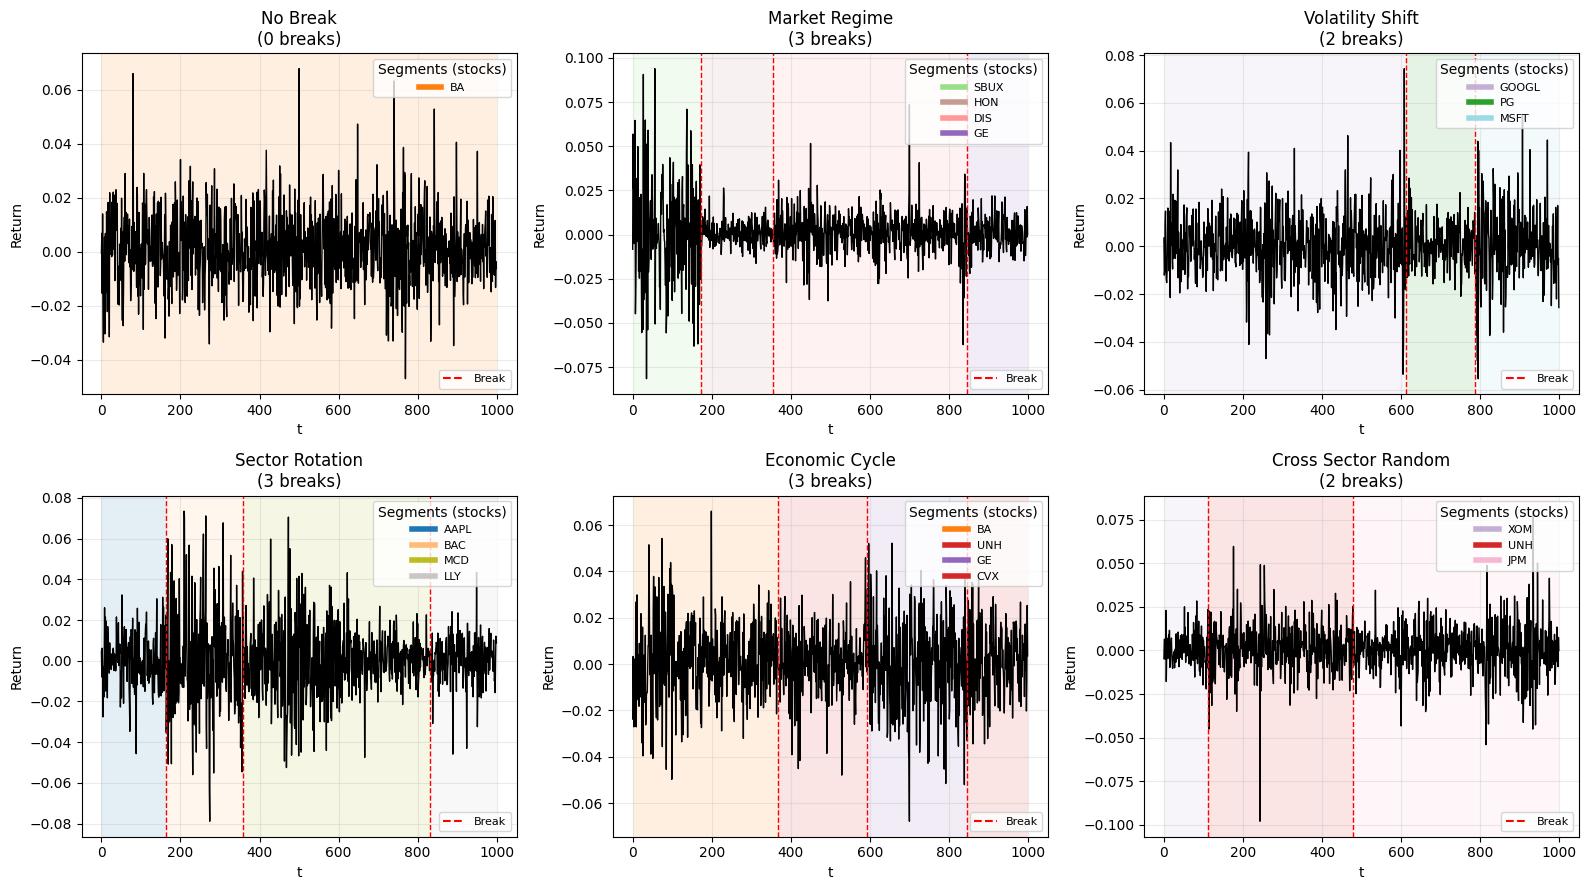

In [9]:
_unique_symbols = sorted({s for syms in real_stock_dataset['stock_symbols'] for s in syms})
_palette = [cm.get_cmap('tab20')(i % 20) for i in range(max(1, len(_unique_symbols)))]
_symbol_to_color = {sym: _palette[i] for i, sym in enumerate(_unique_symbols)}

def plot_real_scenarios_grid(df: pd.DataFrame,
                             seed: int = 42) -> None:
    rng = np.random.RandomState(seed)
    series_cols = sorted([c for c in df.columns if c.startswith('t_')], key=lambda c: int(c.split('_')[1]))

    real_types = [
        'no_break',
        'market_regime',
        'volatility_shift',
        'sector_rotation',
        'economic_cycle',
        'cross_sector_random'
    ]

    # Ensure we have a symbol->color map available
    try:
        symbol_to_color = dict(_symbol_to_color)
    except NameError:
        from matplotlib import cm
        unique_symbols = []
        for syms in df['stock_symbols']:
            for s in syms:
                if s not in unique_symbols:
                    unique_symbols.append(s)
        palette = [cm.get_cmap('tab20')(i % 20) for i in range(max(1, len(unique_symbols)))]
        symbol_to_color = {sym: palette[i] for i, sym in enumerate(unique_symbols)}

    # Pick one representative example per type (prefer more breaks when available)
    examples = []
    for bt in real_types:
        sub = df[df['primary_break_type'] == bt]
        if len(sub) == 0:
            continue
        sub = sub.sort_values(['n_breaks', 'series_id'], ascending=[False, True])
        if len(sub) > 3:
            sub = sub.head(3).sample(1, random_state=seed)
        else:
            sub = sub.head(1)
        examples.append((bt, sub.iloc[0]))

    n_rows, n_cols = 2, 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 9), sharex=False)
    axes = axes.flatten()

    for i in range(n_rows * n_cols):
        ax = axes[i]
        if i >= len(examples):
            ax.axis('off')
            continue

        bt, row = examples[i]
        series = row[series_cols].to_numpy(dtype=float)
        breaks = list(row['break_points'])
        n_breaks = int(row['n_breaks'])
        symbols = list(row['stock_symbols'])

        # Plot series in black for contrast with colored segment shading
        ax.plot(series, color='black', linewidth=1.0)

        # Segment bounds and shading by ticker color
        bounds = [0] + breaks + [len(series)]
        used_symbols = []
        for seg_idx in range(len(bounds) - 1):
            start, end = bounds[seg_idx], bounds[seg_idx + 1]
            sym = symbols[seg_idx] if seg_idx < len(symbols) else 'UNKNOWN'
            color = symbol_to_color.get(sym, (0.8, 0.8, 0.8, 0.3))
            ax.axvspan(start, end, color=color, alpha=0.12, linewidth=0)
            if sym not in used_symbols:
                used_symbols.append(sym)

        # Break lines
        for bp in breaks:
            ax.axvline(bp, color='red', linestyle='--', linewidth=1)

        # Real scenario title only
        title = bt.replace('_', ' ').title()
        ax.set_title(f"{title}\n({n_breaks} break{'s' if n_breaks != 1 else ''})")
        ax.set_xlabel('t')
        ax.set_ylabel('Return')
        ax.grid(True, alpha=0.25)

        # Legend for tickers in this subplot
        handles = [plt.Line2D([0], [0], color=symbol_to_color.get(sym), lw=4, label=sym) for sym in used_symbols]
        if handles:
            leg1 = ax.legend(handles=handles, title='Segments (stocks)', loc='upper right', frameon=True, fontsize=8)
            ax.add_artist(leg1)
        ax.plot([], [], 'r--', label='Break')
        ax.legend(loc='lower right', fontsize=8)

    plt.tight_layout()
    plt.show()

# Clean call (real titles only)
plot_real_scenarios_grid(real_stock_dataset, seed=42)

### 6.1 WBS2 on Real Data


In [19]:
def run_wbs2_on_real_data(dataset: pd.DataFrame, tolerance_percentage: float = 1.0) -> Dict:
    """
    Run WBS2 benchmark on the real stock dataset.

    Args:
        dataset: DataFrame containing the real stock time series data.
        tolerance_percentage: Tolerance for break point matching (as a percentage of series length).

    Returns:
        Dictionary containing WBS2 performance results on the real dataset.
    """
    print("--- Running WBS2 Benchmark on Real Stock Data ---")

    # Initialize WBS2 detector
    # Using default parameters for consistency unless specified
    detector = RWBS2Detector()

    # Dynamically determine series columns based on dataset columns
    series_columns = [col for col in dataset.columns if col.startswith('t_')]
    series_length = len(series_columns)

    if series_length == 0:
        print("Error: Dataset does not contain 't_' columns for series data. Cannot run benchmark.")
        return {}

    time_series_data = dataset[series_columns].values
    true_breaks = dataset['break_points'].tolist()

    print(f"Running WBS2 detection on {len(dataset)} real stock series of length {series_length}...")
    start_time = time.time()

    detected_breaks = []
    detection_times = []

    try:
        for i, series in enumerate(time_series_data):
            if (i + 1) % 20 == 0:
                print(f"Processed {i + 1:,}/{len(dataset):,} series...")

            series_start_time = time.time()
            breaks = detector.detect_breaks_fast(series.astype(float)) # Ensure float type
            series_end_time = time.time()

            detected_breaks.append(breaks)
            detection_times.append(series_end_time - series_start_time)

    except KeyboardInterrupt:
        print("\nBenchmark on real stock series interrupted by user.")
        pass

    total_time = time.time() - start_time

    print(f"Detection completed for {len(detected_breaks)} real stock series in {total_time:.2f} seconds")
    if detection_times:
        print(f"Average time per series: {np.mean(detection_times)*1000:.2f} ms")
    print()

    # Evaluate performance with the specified tolerance percentage
    print(f"Evaluating performance for real stock series with {tolerance_percentage}% tolerance...")
    results_overall = evaluate_detection_performance(true_breaks[:len(detected_breaks)], detected_breaks, series_length, tolerance_percentage)

    print("=== WBS2 Performance Results (Real Stock Data) ===")
    print(f"Tolerance used: {results_overall['tolerance_used']}")
    print(f"Overall Precision: {results_overall['precision']:.3f}")
    print(f"Overall Recall: {results_overall['recall']:.3f}")
    print(f"Overall F1-Score: {results_overall['f1_score']:.3f}")
    print()
    print(f"Average Precision (per series): {results_overall['avg_precision']:.3f}")
    print(f"Average Recall (per series): {results_overall['avg_recall']:.3f}")
    print(f"Average F1-Score (per series): {results_overall['avg_f1']:.3f}")
    print()
    print(f"Average Localization Error: {results_overall['avg_localization_error']:.1f} time points")
    print()
    print(f"Confusion Matrix:")
    print(f"True Positives: {results_overall['true_positives']}")
    print(f"False Positives: {results_overall['false_positives']}")
    print(f"False Negatives: {results_overall['false_negatives']}")


    # Performance by number of breaks
    print("\n=== Performance by Break Count (Real Stock Data) ===")
    break_count_results = defaultdict(lambda: {'tp': 0, 'fp': 0, 'fn': 0, 'count': 0, 'localization_errors': []})

    # Recalculate tolerance for this evaluation block to be explicit
    current_tolerance = max(1, int(series_length * (tolerance_percentage / 100.0)))


    for i in range(len(detected_breaks)):
        true_bp = true_breaks[i]
        detected_bp = detected_breaks[i]
        n_true_breaks = len(true_bp)

        break_count_results[n_true_breaks]['count'] += 1

        tp = 0
        matched_true_indices = set()
        current_localization_errors = []

        for j, det_bp_val in enumerate(detected_bp):
            for k, true_bp_val in enumerate(true_bp):
                if abs(det_bp_val - true_bp_val) <= current_tolerance:
                    if k not in matched_true_indices:
                        matched_true_indices.add(k)
                        tp += 1
                        current_localization_errors.append(abs(det_bp_val - true_bp_val))
                        break

        fp = len(detected_bp) - tp
        fn = n_true_breaks - tp

        break_count_results[n_true_breaks]['tp'] += tp
        break_count_results[n_true_breaks]['fp'] += fp
        break_count_results[n_true_breaks]['fn'] += fn
        break_count_results[n_true_breaks]['localization_errors'].extend(current_localization_errors)

    for n_breaks in sorted(break_count_results.keys()):
        stats = break_count_results[n_breaks]
        precision = stats['tp'] / (stats['tp'] + stats['fp']) if (stats['tp'] + stats['fp']) > 0 else 0
        recall = stats['tp'] / (stats['tp'] + stats['fn']) if (stats['tp'] + stats['fn']) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        avg_loc_error = np.mean(stats['localization_errors']) if stats['localization_errors'] else 0

        print(f"{n_breaks} breaks ({stats['count']} series): P={precision:.3f}, R={recall:.3f}, F1={f1:.3f}, LocErr={avg_loc_error:.1f}")


    # Performance by break type
    print("\n=== Performance by Break Type (Real Stock Data) ===")
    results_by_type = defaultdict(lambda: {'tp': 0, 'fp': 0, 'fn': 0, 'count': 0, 'localization_errors': []})

    for i in range(len(detected_breaks)):
        true_bp = true_breaks[i]
        detected_bp = detected_breaks[i]
        primary_break_type = dataset.iloc[i]['primary_break_type']

        results_by_type[primary_break_type]['count'] += 1

        tp = 0
        matched_true_indices = set()
        current_localization_errors = []

        for j, det_bp_val in enumerate(detected_bp):
            for k, true_bp_val in enumerate(true_bp):
                if abs(det_bp_val - true_bp_val) <= current_tolerance:
                    if k not in matched_true_indices:
                        matched_true_indices.add(k)
                        tp += 1
                        current_localization_errors.append(abs(det_bp_val - true_bp_val))
                        break

        fp = len(detected_bp) - tp
        fn = len(true_bp) - tp

        results_by_type[primary_break_type]['tp'] += tp
        results_by_type[primary_break_type]['fp'] += fp
        results_by_type[primary_break_type]['fn'] += fn
        results_by_type[primary_break_type]['localization_errors'].extend(current_localization_errors)


    for break_type in sorted(results_by_type.keys()):
        stats = results_by_type[break_type]
        total_detected = stats['tp'] + stats['fp']
        total_true = stats['tp'] + stats['fn']

        precision = stats['tp'] / total_detected if total_detected > 0 else 0
        recall = stats['tp'] / total_true if total_true > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        avg_loc_error = np.mean(stats['localization_errors']) if stats['localization_errors'] else 0
        print(f"{break_type.replace('_', ' ').title()} ({stats['count']} series): P={precision:.3f}, R={recall:.3f}, F1={f1:.3f}, LocErr={avg_loc_error:.1f}")


    # Store results in a dictionary
    wbs2_real_results = {
        'overall_precision': results_overall['precision'],
        'overall_recall': results_overall['recall'],
        'overall_f1': results_overall['f1_score'],
        'overall_avg_loc_err': results_overall['avg_localization_error'],
        'results_by_type': dict(results_by_type), # Convert defaultdict to dict
        'results_by_count': dict(break_count_results), # Convert defaultdict to dict
        'mean_runtime_ms': np.mean(detection_times)*1000 if detection_times else 0.0,
        'median_runtime_ms': np.median(detection_times)*1000 if detection_times else 0.0,
        'total_time_s': total_time,
        'n_series': len(dataset),
        'series_length': series_length,
        'tolerance': current_tolerance
    }

    return wbs2_real_results

# Run the WBS2 benchmark on the real stock dataset
wbs2_real_benchmark_results = run_wbs2_on_real_data(real_stock_dataset, tolerance_percentage=1.0)

--- Running WBS2 Benchmark on Real Stock Data ---
Running WBS2 detection on 100 real stock series of length 1000...
Processed 20/100 series...
Processed 40/100 series...
Processed 60/100 series...
Processed 80/100 series...
Processed 100/100 series...
Detection completed for 100 real stock series in 10.97 seconds
Average time per series: 109.69 ms

Evaluating performance for real stock series with 1.0% tolerance...
=== WBS2 Performance Results (Real Stock Data) ===
Tolerance used: 10
Overall Precision: 0.015
Overall Recall: 0.307
Overall F1-Score: 0.029

Average Precision (per series): 0.020
Average Recall (per series): 0.316
Average F1-Score (per series): 0.043

Average Localization Error: 4.9 time points

Confusion Matrix:
True Positives: 35
False Positives: 2296
False Negatives: 79

=== Performance by Break Count (Real Stock Data) ===
0 breaks (24 series): P=0.000, R=0.000, F1=0.000, LocErr=0.0
1 breaks (45 series): P=0.013, R=0.333, F1=0.024, LocErr=4.9
2 breaks (24 series): P=0.02

### 6.2 Spike-and-Slab on Real Data


In [20]:
def run_r_spike_slab_on_real_data(dataset: pd.DataFrame, 
                                   tolerance_percentage: float = 1.0,
                                   q: float = 0.1,
                                   del_threshold: int = 5,
                                   tau2: Optional[float] = None,
                                   tau2_spike: Optional[float] = None,
                                   tau2_slab: Optional[float] = None,
                                   sigma: Optional[float] = None) -> Dict:
    """
    Run R Spike-and-Slab benchmark on the real stock dataset.

    Args:
        dataset: DataFrame containing the real stock time series data.
        tolerance_percentage: Tolerance for break point matching (as a percentage of series length).
        q: Sparsity inducing parameter (default: 0.1)
        del_threshold: Minimum distance between changepoints (default: 5)
        tau2: Shrinkage parameter (default: 2/sqrt(n))
        tau2_spike: Spike variance (default: 1/n)
        tau2_slab: Slab variance (default: n)
        sigma: Noise level (default: auto-estimated)

    Returns:
        Dictionary containing R Spike-and-Slab performance results on the real dataset.
    """
    print("--- Running R Spike-and-Slab Benchmark on Real Stock Data ---")

    # Dynamically determine series columns based on dataset columns
    series_columns = [col for col in dataset.columns if col.startswith('t_')]
    series_length = len(series_columns)

    if series_length == 0:
        print("Error: Dataset does not contain 't_' columns for series data. Cannot run benchmark.")
        return {}

    X = dataset[series_columns].values
    true_breaks_list = dataset['break_points'].tolist()

    # Initialize R Spike-and-Slab detector
    detector = SpikeAndSlabDetector(
        q=q,
        tau2=tau2,
        tau2_spike=tau2_spike,
        tau2_slab=tau2_slab,
        sigma=sigma,
        del_threshold=del_threshold
    )

    # Run detection loop with progress & timing
    print(f"Running R Spike-and-Slab detection on {len(dataset)} real stock series of length {series_length}...")
    print(f"Parameters: q={q}, del_threshold={del_threshold}")
    start_time = time.time()
    
    detected_breaks_list = []
    inclusion_probs_list = []
    runtimes_ms = []

    try:
        for i, y in enumerate(X):
            if (i + 1) % 20 == 0:
                print(f"Processed {i + 1:,}/{len(dataset):,} series...")

            t0 = time.time()
            try:
                # Detect changepoints
                breaks = detector.detect_breaks_fast(y.astype(float))
                
                # Get inclusion probabilities for later analysis
                probs = detector.get_inclusion_probabilities(y.astype(float))
                
            except Exception as e:
                print(f"Error processing series {i}: {e}")
                breaks = []
                probs = {'ratio': np.zeros(len(y))}
            
            t1 = time.time()
            runtime_ms = (t1 - t0) * 1000.0
            
            detected_breaks_list.append(breaks)
            inclusion_probs_list.append(probs['ratio'])
            runtimes_ms.append(runtime_ms)

    except KeyboardInterrupt:
        print("\nBenchmark on real stock series interrupted by user.")

    total_time = time.time() - start_time
    print(f"\n=== Timing Results for Real Stock Data ===")
    if runtimes_ms:
        print(f"Total time: {total_time:.2f} s  |  Avg per series: {np.mean(runtimes_ms):.2f} ms")
    else:
        print("No series were processed.")

    # Calculate evaluation tolerance
    evaluation_tolerance = max(1, int(series_length * (tolerance_percentage / 100.0)))
    print(f"\nUsing tolerance of {evaluation_tolerance} for evaluation ({tolerance_percentage}% of length {series_length})")

    # Evaluation
    total_tp, total_fp, total_fn = 0, 0, 0
    all_localization_errors = []
    per_series_precision = []
    per_series_recall = []
    per_series_f1 = []

    for i in range(len(detected_breaks_list)):
        true_breaks = true_breaks_list[i]
        detected_breaks = detected_breaks_list[i]

        # Calculate TP, FP, FN, and localization errors
        tp = 0
        matched_true_indices = set()
        current_localization_errors = []

        for det_bp in detected_breaks:
            for k, true_bp_k in enumerate(true_breaks):
                if abs(det_bp - true_bp_k) <= evaluation_tolerance:
                    if k not in matched_true_indices:
                        matched_true_indices.add(k)
                        tp += 1
                        current_localization_errors.append(abs(det_bp - true_bp_k))
                        break

        fp = len(detected_breaks) - tp
        fn = len(true_breaks) - tp

        total_tp += tp
        total_fp += fp
        total_fn += fn
        all_localization_errors.extend(current_localization_errors)

        # Per-series metrics (only if there are breaks to find)
        if len(detected_breaks) > 0:
            per_series_precision.append(tp / len(detected_breaks))
        if len(true_breaks) > 0:
            per_series_recall.append(tp / len(true_breaks))
            if len(detected_breaks) > 0:
                prec = tp / len(detected_breaks)
                rec = tp / len(true_breaks)
                f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0
                per_series_f1.append(f1)

    # Calculate overall metrics
    overall_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
    overall_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
    overall_f1 = 2 * overall_precision * overall_recall / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0.0
    overall_avg_localization_error = float(np.mean(all_localization_errors)) if all_localization_errors else 0.0

    # Calculate average metrics
    avg_precision = float(np.mean(per_series_precision)) if per_series_precision else 0.0
    avg_recall = float(np.mean(per_series_recall)) if per_series_recall else 0.0
    avg_f1 = float(np.mean(per_series_f1)) if per_series_f1 else 0.0

    print(f"\n=== Overall Performance Results (Real Stock Data) ===")
    print(f"Overall Precision: {overall_precision:.3f}")
    print(f"Overall Recall: {overall_recall:.3f}")
    print(f"Overall F1-Score: {overall_f1:.3f}")
    print(f"Overall Avg Localization Error: {overall_avg_localization_error:.1f} time points")
    print()
    print(f"Average Precision (per series): {avg_precision:.3f}")
    print(f"Average Recall (per series): {avg_recall:.3f}")
    print(f"Average F1-Score (per series): {avg_f1:.3f}")
    print(f"\nConfusion Matrix (Total):")
    print(f"True Positives: {total_tp}")
    print(f"False Positives: {total_fp}")
    print(f"False Negatives: {total_fn}")

    # Performance by break type
    print(f"\n=== Performance by Break Type (Real Stock Data) ===")
    results_by_type = defaultdict(lambda: {'tp': 0, 'fp': 0, 'fn': 0, 'count': 0, 'localization_errors': []})

    for i in range(len(detected_breaks_list)):
        true_bp = true_breaks_list[i]
        detected_bp = detected_breaks_list[i]
        primary_break_type = dataset.iloc[i]['primary_break_type']

        results_by_type[primary_break_type]['count'] += 1

        tp = 0
        matched_true_indices = set()
        current_localization_errors = []

        for det_bp in detected_bp:
            for k, true_bp_k in enumerate(true_bp):
                if abs(det_bp - true_bp_k) <= evaluation_tolerance:
                    if k not in matched_true_indices:
                        matched_true_indices.add(k)
                        tp += 1
                        current_localization_errors.append(abs(det_bp - true_bp_k))
                        break

        fp = len(detected_bp) - tp
        fn = len(true_bp) - tp

        results_by_type[primary_break_type]['tp'] += tp
        results_by_type[primary_break_type]['fp'] += fp
        results_by_type[primary_break_type]['fn'] += fn
        results_by_type[primary_break_type]['localization_errors'].extend(current_localization_errors)

    for break_type in sorted(results_by_type.keys()):
        stats = results_by_type[break_type]
        total_detected = stats['tp'] + stats['fp']
        total_true = stats['tp'] + stats['fn']

        precision = stats['tp'] / total_detected if total_detected > 0 else 0
        recall = stats['tp'] / total_true if total_true > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        avg_loc_error = np.mean(stats['localization_errors']) if stats['localization_errors'] else 0
        print(f"{break_type.replace('_', ' ').title()} ({stats['count']} series): P={precision:.3f}, R={recall:.3f}, F1={f1:.3f}, LocErr={avg_loc_error:.1f}")

    # Performance by break count
    print(f"\n=== Performance by Break Count (Real Stock Data) ===")
    results_by_count = defaultdict(lambda: {'tp': 0, 'fp': 0, 'fn': 0, 'count': 0, 'localization_errors': []})

    for i in range(len(detected_breaks_list)):
        true_bp = true_breaks_list[i]
        detected_bp = detected_breaks_list[i]
        n_true_breaks = len(true_bp)

        results_by_count[n_true_breaks]['count'] += 1

        tp = 0
        matched_true_indices = set()
        current_localization_errors = []

        for det_bp in detected_bp:
            for k, true_bp_k in enumerate(true_bp):
                if abs(det_bp - true_bp_k) <= evaluation_tolerance:
                    if k not in matched_true_indices:
                        matched_true_indices.add(k)
                        tp += 1
                        current_localization_errors.append(abs(det_bp - true_bp_k))
                        break

        fp = len(detected_bp) - tp
        fn = n_true_breaks - tp

        results_by_count[n_true_breaks]['tp'] += tp
        results_by_count[n_true_breaks]['fp'] += fp
        results_by_count[n_true_breaks]['fn'] += fn
        results_by_count[n_true_breaks]['localization_errors'].extend(current_localization_errors)

    for n_breaks in sorted(results_by_count.keys()):
        stats = results_by_count[n_breaks]
        precision = stats['tp'] / (stats['tp'] + stats['fp']) if (stats['tp'] + stats['fp']) > 0 else 0
        recall = stats['tp'] / (stats['tp'] + stats['fn']) if (stats['tp'] + stats['fn']) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        avg_loc_error = np.mean(stats['localization_errors']) if stats['localization_errors'] else 0

        print(f"{n_breaks} breaks ({stats['count']} series): P={precision:.3f}, R={recall:.3f}, F1={f1:.3f}, LocErr={avg_loc_error:.1f}")

    # Store results
    r_spike_slab_results = {
        'overall_precision': overall_precision,
        'overall_recall': overall_recall,
        'overall_f1': overall_f1,
        'overall_avg_loc_err': overall_avg_localization_error,
        'avg_precision': avg_precision,
        'avg_recall': avg_recall,
        'avg_f1': avg_f1,
        'results_by_type': dict(results_by_type),
        'results_by_count': dict(results_by_count),
        'mean_runtime_ms': np.mean(runtimes_ms) if runtimes_ms else 0.0,
        'median_runtime_ms': np.median(runtimes_ms) if runtimes_ms else 0.0,
        'total_time_s': total_time,
        'n_series': len(dataset),
        'series_length': series_length,
        'tolerance': evaluation_tolerance,
        'q': q,
        'del_threshold': del_threshold,
        'detected_breaks': detected_breaks_list,
        'inclusion_probabilities': inclusion_probs_list
    }

    return r_spike_slab_results


# Run the R Spike-and-Slab benchmark on the real stock dataset
r_spike_slab_real_results = run_r_spike_slab_on_real_data(
    real_stock_dataset, 
    tolerance_percentage=1.0,
    q=0.3,              # Tune this
    del_threshold=40     # And this
)

--- Running R Spike-and-Slab Benchmark on Real Stock Data ---
Running R Spike-and-Slab detection on 100 real stock series of length 1000...
Parameters: q=0.3, del_threshold=40
Processed 20/100 series...
Processed 40/100 series...
Processed 60/100 series...
Processed 80/100 series...
Processed 100/100 series...

=== Timing Results for Real Stock Data ===
Total time: 15.03 s  |  Avg per series: 150.32 ms

Using tolerance of 10 for evaluation (1.0% of length 1000)

=== Overall Performance Results (Real Stock Data) ===
Overall Precision: 0.032
Overall Recall: 0.167
Overall F1-Score: 0.054
Overall Avg Localization Error: 3.9 time points

Average Precision (per series): 0.031
Average Recall (per series): 0.164
Average F1-Score (per series): 0.059

Confusion Matrix (Total):
True Positives: 19
False Positives: 567
False Negatives: 95

=== Performance by Break Type (Real Stock Data) ===
Cross Sector Random (13 series): P=0.025, R=0.105, F1=0.041, LocErr=5.0
Economic Cycle (14 series): P=0.036, 

### 6.3 BiLSTM on Real Data


In [21]:
def run_bilstm_on_real_data(dataset: pd.DataFrame, bilstm_detector: CleanBiLSTMDetector,
                            detection_threshold: float = 0.6, detection_stride: int = 15,
                            tolerance_percentage: float = 1.0) -> Dict:
    """
    Run BiLSTM benchmark on the real stock dataset.

    Args:
        dataset: DataFrame containing the real stock time series data.
        bilstm_detector: An instance of the trained CleanBiLSTMDetector.
        detection_threshold: Detection threshold for the BiLSTM output.
        detection_stride: Stride for the sliding window detection.
        tolerance_percentage: Tolerance for break point matching (as a percentage of series length).

    Returns:
        Dictionary containing BiLSTM performance results on the real dataset.
    """
    print("--- Running BiLSTM Benchmark on Real Stock Data ---")

    if not bilstm_detector.trained:
        print("Error: BiLSTM detector is not trained or loaded. Cannot run benchmark.")
        return {}

    # Dynamically determine series columns based on dataset columns
    series_columns = [col for col in dataset.columns if col.startswith('t_')]
    series_length = len(series_columns)

    if series_length == 0:
        print("Error: Dataset does not contain 't_' columns for series data. Cannot run benchmark.")
        return {}

    time_series_data = dataset[series_columns].values
    true_breaks_list = dataset['break_points'].tolist()

    print(f"Running BiLSTM detection on {len(dataset)} real stock series of length {series_length}...")
    start_time = time.time()

    detected_breaks = []
    detection_times = []

    try:
        for i, series in enumerate(time_series_data):
            if (i + 1) % 20 == 0:
                print(f"Processed {i + 1:,}/{len(dataset):,} series...")

            series_start_time = time.time()
            breaks = bilstm_detector.detect_breaks(
                series.astype(float), # Ensure float type
                threshold=detection_threshold,
                stride=detection_stride
            )
            series_end_time = time.time()

            detected_breaks.append(breaks)
            detection_times.append(series_end_time - series_start_time)

    except KeyboardInterrupt:
        print("\nBenchmark on real stock series interrupted by user.")
        pass

    total_time = time.time() - start_time

    print(f"Detection completed for {len(detected_breaks)} real stock series in {total_time:.2f} seconds")
    if detection_times:
        print(f"Average time per series: {np.mean(detection_times)*1000:.2f} ms")
    print()

    # Evaluate performance with the specified tolerance percentage
    print(f"Evaluating performance for real stock series with {tolerance_percentage}% tolerance...")
    # Need to adapt evaluation functions for BiLSTM output (list of lists)
    # Re-implementing evaluation logic here or using the adapted functions from earlier cells
    # Assuming evaluate_bilstm_by_break_type and evaluate_bilstm_by_break_count are available

    # Calculate tolerance based on series length and percentage
    evaluation_tolerance = max(1, int(series_length * (tolerance_percentage / 100.0)))
    print(f"\nUsing tolerance of {evaluation_tolerance} for evaluation ({tolerance_percentage}% of length {series_length})")


    # Calculate overall metrics
    total_tp, total_fp, total_fn = 0, 0, 0
    all_localization_errors = []
    # Per-series metrics are not calculated in the WBS2 benchmark style,
    # so we'll stick to overall and by-group metrics.


    for i in range(len(dataset)):
        true_breaks = true_breaks_list[i]
        detected_bp = detected_breaks[i]

        # Calculate TP, FP, FN, and localization errors for the current series
        tp = 0
        matched_true_indices = set()
        matched_detected_indices = set()
        current_localization_errors = []

        for j, det_bp_val in enumerate(detected_bp): # Iterate through detected break points
            for k, true_bp_val in enumerate(true_breaks): # Iterate through true break points
                if abs(det_bp_val - true_bp_val) <= evaluation_tolerance: # Compare detected to true with tolerance
                    if k not in matched_true_indices: # Ensure each true break is matched only once
                        matched_true_indices.add(k)
                        matched_detected_indices.add(j)
                        tp += 1
                        current_localization_errors.append(abs(det_bp_val - true_bp_val))
                        break # Move to the next detected break (found a match for this one)

            fp = len(detected_bp) - tp
            fn = len(true_breaks) - len(matched_true_indices)

            total_tp += tp
            total_fp += fp
            total_fn += fn
            all_localization_errors.extend(current_localization_errors)


    # Calculate overall metrics
    overall_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
    overall_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
    overall_f1 = 2 * overall_precision * overall_recall / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0.0
    overall_avg_localization_error = float(np.mean(all_localization_errors)) if all_localization_errors else 0.0


    print(f"\n=== Overall Performance Results (Real Stock Data) ===")
    print(f"Overall Precision: {overall_precision:.3f}")
    print(f"Overall Recall: {overall_recall:.3f}")
    print(f"Overall F1-Score: {overall_f1:.3f}")
    print(f"Overall Avg Localization Error: {overall_avg_localization_error:.1f} time points")
    print(f"\nConfusion Matrix (Total):")
    print(f"True Positives: {total_tp}")
    print(f"False Positives: {total_fp}")
    print(f"False Negatives: {total_fn}")

    # Evaluate by break type (using the adapted function)
    try:
        results_by_type = evaluate_bilstm_by_break_type(dataset, detected_breaks)
        print(f"\n=== Performance by Break Type (Real Stock Data) ===")
        for break_type, stats in results_by_type.items():
             print(f"{break_type.replace('_',' ').title()} ({stats['n_series']} series):  "
                   f"P={stats['precision']:.3f}  R={stats['recall']:.3f}  F1={stats['f1_score']:.3f}  "
                   f"LocErr={stats['avg_localization_error']:.1f}")
    except NameError:
         print("Error: evaluate_bilstm_by_break_type function not found. Please ensure the cell defining it is run.")
         results_by_type = {}
    except Exception as e:
         print(f"Error during type evaluation: {e}")
         results_by_type = {}


    # Evaluate by break count (using the adapted function)
    try:
        results_by_count = evaluate_bilstm_by_break_count(dataset, detected_breaks)
        print(f"\n=== Performance by Break Count (Real Stock Data) ===")
        for k in sorted(results_by_count.keys()):
            s = results_by_count[k]
            print(f"{k} breaks ({s['count']} series):  "
                  f"P={s['precision']:.3f}  R={s['recall']:.3f}  F1={s['f1_score']:.3f}  LocErr={s.get('avg_localization_error', 0.0):.1f}")
    except NameError:
        print("Error: evaluate_bilstm_by_break_count function not found. Please ensure the cell defining it is run.")
        results_by_count = {}
    except Exception as e:
         print(f"Error during count evaluation: {e}")
         results_by_count = {}


    # Store results in a dictionary
    bilstm_real_results = {
        'overall_precision': overall_precision,
        'overall_recall': overall_recall,
        'overall_f1': overall_f1,
        'overall_avg_loc_err': overall_avg_localization_error,
        'results_by_type': dict(results_by_type), # Convert defaultdict to dict
        'results_by_count': dict(results_by_count), # Convert defaultdict to dict
        'mean_runtime_ms': np.mean(detection_times) if detection_times else 0.0,
        'median_runtime_ms': np.median(detection_times) if detection_times else 0.0,
        'total_time_s': total_time,
        'n_series': len(dataset),
        'series_length': series_length,
        'detection_threshold': detection_threshold,
        'detection_stride': detection_stride,
        'tolerance': evaluation_tolerance
    }

    return bilstm_real_results

# Run the BiLSTM benchmark on the real stock dataset
# Check if the bilstm_detector object exists and is trained
if 'bilstm_detector' in locals() and bilstm_detector.trained:
    bilstm_real_benchmark_results = run_bilstm_on_real_data(
        real_stock_dataset,
        bilstm_detector,
        detection_threshold=0.6, # Use the threshold from training
        detection_stride=10,
        tolerance_percentage=1.0
    )
else:
    print("BiLSTM detector not trained or loaded. Skipping BiLSTM benchmark on real data.")
    bilstm_real_benchmark_results = None

--- Running BiLSTM Benchmark on Real Stock Data ---
Running BiLSTM detection on 100 real stock series of length 1000...
Processed 20/100 series...
Processed 40/100 series...
Processed 60/100 series...
Processed 80/100 series...
Processed 100/100 series...
Detection completed for 100 real stock series in 64.58 seconds
Average time per series: 645.76 ms

Evaluating performance for real stock series with 1.0% tolerance...

Using tolerance of 10 for evaluation (1.0% of length 1000)

=== Overall Performance Results (Real Stock Data) ===
Overall Precision: 0.034
Overall Recall: 0.212
Overall F1-Score: 0.058
Overall Avg Localization Error: 4.0 time points

Confusion Matrix (Total):
True Positives: 160
False Positives: 4583
False Negatives: 593
Using tolerance of 10 for evaluation by break type (1.0% of length 1000)

=== Performance by Break Type (Real Stock Data) ===
Cross Sector Random (13 series):  P=0.086  R=0.368  F1=0.140  LocErr=4.1
Economic Cycle (14 series):  P=0.083  R=0.450  F1=0.14